# Lesson 2 - Data cleaning and exploratory data analysis

> A walkthrough on the fundamental mechanics to manipulate the data contained in `pandas.Series` or `pandas.DataFrame` objects.

## Learning objectives

* Visualise geographical data with seaborn
* Slice, mask, and index `pandas.Series` and `pandas.DataFrame` objects
* Merge one or more `pandas.DataFrame` objects together on a common key
* Apply the `DataFrame.groupby()` operation to aggregate data conditionally across different groups of interest

## References

* Chapter 2 of _Hands-On Machine Learning with Scikit-Learn and TensorFlow_ by Aurèlien Geron.
* Chapter 3 of _Python Data Science Handbook_ by Jake Vanderplas.

## What is data cleaning?

<img src='./images/data-cleaning.png' width='400'>

When you receive a new dataset at the beginning of a project, the first task usually involves some form of data cleaning. 

To achieve your goal, you might need data from multiple sources which you need to combine into one unified table. However, this is usually a tricky task; the different data sources might have different naming conventions, some of them might be human entered while others are automatic system reports. A list of things you usually have to go through are the following:

* Merge multiple sources into one table
* Remove duplicate entries
* Clean corrupted entries
* Handle missing data

While building algorithms that are able to classify data or estimate outcomes is arguably the most interesting part of data science, data cleaning is the one that takes up most of the time. According to a study by CrowdFlower, data scientist spend about 80% of their time preparing data sets.

<img src='images/What-data-scientists-spend-the-most-time-doing.jpg' width='400'>
<p style="text-align: center;"> <b>Figure:</b> A survey of 80 data scientist shows what they spend most time on. </p>

## Import libraries

As usual, we will be making use of the pandas and seaborn libraries. It is often a good idea to import all your libraries in a single cell block near the top of your notebooks so that your collaborators can quickly see whether they need to install new libraries or not.

In [1]:
# reload modules before executing user code
%load_ext autoreload
# reload all modules every time before executing the Python code
%autoreload 2
# render plots in notebook
%matplotlib inline

---
**You should know**

Jupyter notebooks have special commands (which are not built into Python itself) that are known as "magic" commands. They are designed to automate common tasks and easily control the Jupyter environment. A magic comman is any command prefixed by the percent symbol %. For example, the magic command `autoreload`  above automatically reloads modules so that we don't have to restart the notebook everytime we make changes to an external file.

We encourage you to explore all of the special commands available by typing `%quickref` or `%magic` into a code cell.

---

In [41]:
# data wrangling
import pandas as pd
import numpy as np
from pathlib import Path

# data viz
import seaborn as sns
import matplotlib.pyplot as plt

# these commands define the color scheme
sns.set(color_codes=True)
sns.set_palette(sns.color_palette('muted'))

## Load the data

In this notebook we will continue analysing the California housing dataset from [Kaggle](https://www.kaggle.com/camnugent/california-housing-prices), but we will also include external data from the neighbourhoods associated with each house.

As usual, we make use of the `pathlib` library to handle our filepaths:

In [3]:
DATA = Path('../data/')
!ls {DATA}

housing.csv                housing_gmaps_data_raw.csv
housing_addresses.csv


In [8]:
housing_data = pd.read_csv(DATA/'housing.csv'); housing_data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [13]:
housing_data.shape

(20640, 11)

In [9]:
housing_addresses = pd.read_csv(DATA/'housing_addresses.csv'); housing_addresses.head()

,street_number,street_name,city,postal_code,latitude_longitude
0,3130,Grizzly Peak Boulevard,Berkeley,94705.0,"37.88,-122.23"
1,2005,Tunnel Road,Oakland,94611.0,"37.86,-122.22"
2,6886,Chabot Road,Oakland,94618.0,"37.85,-122.24"
3,6365,Florio Street,Oakland,94618.0,"37.85,-122.25"
4,5407,Bryant Avenue,Oakland,94618.0,"37.84,-122.25"


## Inspect the data

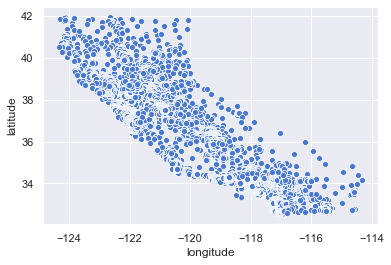

In [60]:
sns.scatterplot(x="longitude", y="latitude", data=housing_data);

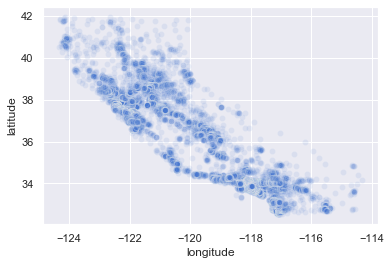

In [65]:
sns.scatterplot(x="longitude", y="latitude", data=housing_data, alpha=0.1);

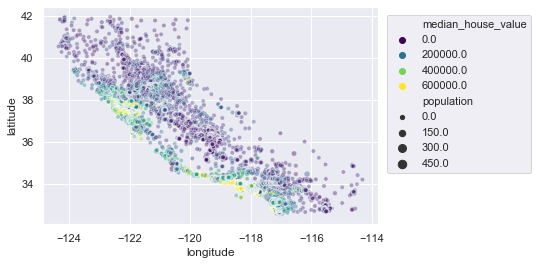

In [70]:
fig = sns.scatterplot(
    x="longitude",
    y="latitude",
    data=housing_data,
    alpha=0.4,
    hue="median_house_value",
    legend="brief",
    palette="viridis",
    size=housing_data["population"] / 100,
)

fig.legend(loc='center left', bbox_to_anchor=(1.01, 0.6), ncol=1)



## Indexing, selection, and filtering

Pandas provides several methods to access, set, and modify `Series` and `DataFrame` objects. Here we consider the most common ones that are needed to slic and dice data to one's needs.

### Series

A `Series` object provides array-style item selection that allows one to perform _slicing, masking,_ and _fancy indexing_. Examples of these are as follows:

In [28]:
# define a new Series object from existing columns
rooms_per_household = (
    housing_data["total_rooms"] / housing_data["households"]
)

In [29]:
rooms_per_household

0        6.984127
1        6.238137
2        8.288136
3        5.817352
4        6.281853
           ...   
20635    5.045455
20636    6.114035
20637    5.205543
20638    5.329513
20639    5.254717
Length: 20640, dtype: float64

In [30]:
# get first entry
rooms_per_household[0]

6.984126984126984

In [31]:
# slicing by index
rooms_per_household[2:5]

2    8.288136
3    5.817352
4    6.281853
dtype: float64

In [32]:
# slice and just get values
rooms_per_household[2:5].values

array([8.28813559, 5.8173516 , 6.28185328])

In [33]:
rooms_per_household.describe()

count    20640.000000
mean         5.429000
std          2.474173
min          0.846154
25%          4.440716
50%          5.229129
75%          6.052381
max        141.909091
dtype: float64

In [34]:
# masking (filtering)
rooms_per_household[(rooms_per_household > 10.) & (rooms_per_household < 20.)]

1023     10.515306
1030     10.168591
1233     16.847534
1235     13.473039
1236     11.490862
           ...    
20089    10.845815
20092    11.428005
20110    11.458508
20112    11.536585
20113    17.300000
Length: 157, dtype: float64

In [35]:
# fancy indexing
rooms_per_household[[0, 4]]

0    6.984127
4    6.281853
dtype: float64

## Merging DataFrames

One of the most common operations in pandas (or data science for that matter) is the combination of data contained in various objects. In particular, _**merge**_ or _**join**_ operations combine datasets by linking rows using one of more _**keys**_. These operations are central to relational databases (e.g. SQL-based). The `merge` function in pandas is the main entry point for using these algorithms on your data. 

Let's use this to combine the `housing_data` and `housing_addresses` `DataFrames` via their common latitude and longitude coordinates.

In [10]:
housing_data['latitude_longitude'] = housing_data['latitude'].map(str) + ',' + housing_data['longitude'].map(str)

In [11]:
housing_merged = pd.merge(housing_data, housing_addresses, how='left', on='latitude_longitude')

In [12]:
housing_merged.shape

(20640, 15)

In [14]:
housing_merged.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,latitude_longitude,street_number,street_name,city,postal_code
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,"37.88,-122.23",3130,Grizzly Peak Boulevard,Berkeley,94705.0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,"37.86,-122.22",2005,Tunnel Road,Oakland,94611.0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,"37.85,-122.24",6886,Chabot Road,Oakland,94618.0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,"37.85,-122.25",6365,Florio Street,Oakland,94618.0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,"37.85,-122.25",6365,Florio Street,Oakland,94618.0


Boom! We now have a single `DataFrame` that links information for house prices and attributes and their addresses.

---
**You should know**

The merge operation above is an example of a _left join_, namely we use all the key combinations of `latitude_longitude` found in the left table `housing_data`. In general the `'how'` argument of `pd.merge()` allows four different join types:

* `'left'`: Use all key combinations found in the left table
* `'right'`: Use all key combinations found in the right table
* `'inner'`: Use only the key combinations observed in both tables
* `'outer'`: Use all key combinations observed in both tables together

A visual example of these different merges in action is shown in the figure below.

<br>
<img src='images/joins.png' width='800'>
<p style="text-align: center;"> <b>Figure:</b> Graphical representation of the different types of merges between two DataFrames df1 and df2 that are possible in pandas. </p>

---

## Which city has the most houses?

Whenever you need to quickly find the frequencies associated with categorical data, the `value_counts` function comes in handy. For example, if we want to see which city has the most houses, we can run the following:

In [15]:
housing_merged['city'].value_counts().nlargest(15)

Los Angeles       2372
San Diego          809
San Francisco      574
San Jose           498
Sacramento         422
Oakland            374
Long Beach         317
Fresno             309
Stockton           242
Bakersfield        222
Anaheim            196
Riverside          168
Modesto            168
Santa Ana          153
San Bernardino     141
Name: city, dtype: int64

## Which city has the most expensive houses?

In [19]:
housing_merged.groupby('city', as_index=False)['median_house_value'].mean().nlargest(10, columns='median_house_value')

,city,median_house_value
61,Bell Canyon,500001.0
97,Bradbury,500001.0
119,Calabasas,500001.0
375,Hidden Hills,500001.0
378,Hillsborough,500001.0
506,Los Altos Hills,500001.0
664,Palos Verdes Estates,500001.0
757,Rolling Hills,500001.0
762,Ross,500001.0
871,Summerland,500001.0


## GroupBy mechanics

The group operation above can be best understood by the H. Wickam's [_split-apply-combine_](https://medium.com/analytics-vidhya/split-apply-combine-strategy-for-data-mining-4fd6e2a0cc99) strategy, where you break up a big problem into manageable pieces, operate on each piece independently and then put all the pieces back together. 

**Split:**
In the first stage of the process, data contained in a `Series` or `DataFrame` object is _split_ into groups based on one or more specified _keys_. The splitting is performed on a particular _axis_ of the object (see the notebook from lesson 2). For example, a `DataFrame` can be grouped on its rows (`axis=0`) or its columns (`axis=1`).

**Apply:**
Once the split done, a function is _applied_ to each group, producing a new value. 

**Combine:**
Finally, the results of all those function applications are _combined_ into a result object. The form of the resulting object will usualy depend on the what's being done to the data.

See the figure below for an example of a simple group aggregation.

<br>
<img src='./images/split-apply-combine.png' width='600'>
<p style="text-align: center;"> <b>Figure:</b> Illustraion of a group aggregation. </p>

In general, the grouping key can take many forms and the key do not have to be all of the same type. Frequently, the grouping information is found in the same `DataFrame` as the data you want to work on, so the key is usually a _column name_. For example let's create a simple `DataFrame` as follows:

In [61]:
df_foo = pd.DataFrame(
    {
        "key1": ["a", "a", "b", "b", "a"],
        "key2": ["one", "two", "one", "two", "one"],
        "data1": np.random.randn(5),
        "data2": np.random.randn(5),
    }
)
df_foo

,key1,key2,data1,data2
0,a,one,-0.748639,1.198950
1,a,two,-0.671999,-0.078311
2,b,one,-0.197011,-0.893382
3,b,two,0.297298,-0.148775
4,a,one,0.263770,0.595468


We can then use the column names as the group keys (similar to what we did above with the beers):

In [62]:
grouped = df_foo.groupby('key1'); grouped

This `grouped` variable is now a _GroupBy_ object. It has not actually calculated anything yet except for some intermediate data about the group key `df_foo['key1']`. The main idea is that this object has all of the information needed to then apply some operation to each of the groups. For example, we can get the mean per group as follows:

In [63]:
df_grouped = grouped.mean(); df_grouped

,data1,data2
key1,,
a,-0.385623,0.572036
b,0.050143,-0.521079


We can also group on more than one key at once to return something different, e.g.

In [64]:
df_multi_grouped = df_foo.groupby(['key1', 'key2']).mean(); df_multi_grouped

data1     data2
key1 key2                    
a    one  -0.242435  0.897209
     two  -0.671999 -0.078311
b    one  -0.197011 -0.893382
     two   0.297298 -0.148775